# Configure system to add impots path

In [5]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, './src')

# Setup Model

In [6]:
import os
from easydict import EasyDict as edict
from src.models.model_utils import create_model
import torch

In [7]:
working_dir = '../'

config = {
    "gpu_idx":0,
    "num_samples":1,
    "no_cuda":False,
    "classnames_infor_path":'./dataset/kitti/classes_names.txt',
    "batch_size":1,
    "num_workers":1,
    "arch":"darknet",
    "cfgfile":"./src/config/cfg/complex_yolov4.cfg",
    "use_giou_loss":True,
    "pretrained_path":"./checkpoints/complex_yolov4/complex_yolov4_mse_loss.pth",
    "saved_fn":"complexer_yolov4",
    "output_video_fn":'out_complexer_yolov4',
    "img_size":608,
    "conf_thresh":0.5,
    "nms_thresh":0.5,
    "iou_thresh":0.5,
    "pin_memory":True,
    "distributed":False,
    "dataset_dir":"./example/dataset/kitti"
    }

configs = edict(config)

device_string = 'cpu' if configs.no_cuda else 'cuda:{}'.format(configs.gpu_idx)
configs.device = torch.device('cpu' if configs.no_cuda else 'cuda:{}'.format(configs.gpu_idx))

configs

{'gpu_idx': 0,
 'num_samples': 1,
 'no_cuda': False,
 'classnames_infor_path': './dataset/kitti/classes_names.txt',
 'batch_size': 1,
 'num_workers': 1,
 'arch': 'darknet',
 'cfgfile': './src/config/cfg/complex_yolov4.cfg',
 'use_giou_loss': True,
 'pretrained_path': './checkpoints/complex_yolov4/complex_yolov4_mse_loss.pth',
 'saved_fn': 'complexer_yolov4',
 'output_video_fn': 'out_complexer_yolov4',
 'img_size': 608,
 'conf_thresh': 0.5,
 'nms_thresh': 0.5,
 'iou_thresh': 0.5,
 'pin_memory': True,
 'distributed': False,
 'dataset_dir': './example/dataset/kitti',
 'device': device(type='cuda', index=0)}

# Load Model

In [8]:
model = create_model(configs)
model.load_state_dict(torch.load(configs.pretrained_path, map_location=device_string))
model = model.to(device=configs.device)

using darknet
[INFO] No error, the convolution haven't activate linear
[INFO] No error, the convolution haven't activate linear
[INFO] No error, the convolution haven't activate linear


Verificar model:

In [9]:
model.eval()

Darknet(
  (models): ModuleList(
    (0): Sequential(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (mish1): Mish()
    )
    (1): Sequential(
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (mish2): Mish()
    )
    (2): Sequential(
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (mish3): Mish()
    )
    (3): EmptyModule()
    (4): Sequential(
      (conv4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (mish4): Mish()
    )
    (5): Sequential(
      (conv5): C

# Load Lidar Data

In [10]:
import numpy as np
import os
from src.data_process import kitti_bev_utils
import src.config.kitti_config as cnf
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

In [11]:
lidar_root = "./exmple/dataset/kitti/testing"

## Functions to convert LiDAR Cloud Points to RGB Image

In [12]:
def get_lidar(idx):
    lidar_dir = Path(f'{lidar_root}/velodyne')
    lidar_file = os.path.join(lidar_dir, '{}.bin'.format(idx))
    # assert os.path.isfile(lidar_file)
    return np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)

def load_img_only(index):
    """Load only image for the testing phase"""
    image_dir = f'{lidar_root}/image'
    sample_id = index
    lidarData = get_lidar(sample_id)
    b = kitti_bev_utils.removePoints(lidarData, cnf.boundary)
    rgb_map = kitti_bev_utils.makeBVFeature(b, cnf.DISCRETIZATION, cnf.boundary)
    img_path = os.path.join(image_dir, '{}.png'.format(sample_id))
    img_file = cv2.imread(img_path)

    return img_file, rgb_map

## Testing on first image

In [13]:
index = "000002" # Item name

In [14]:
img_rgb, img_lidar = load_img_only(index)

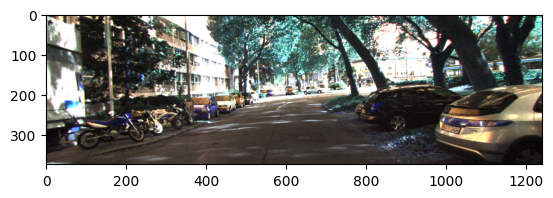

In [15]:
plt.imshow(img_rgb)

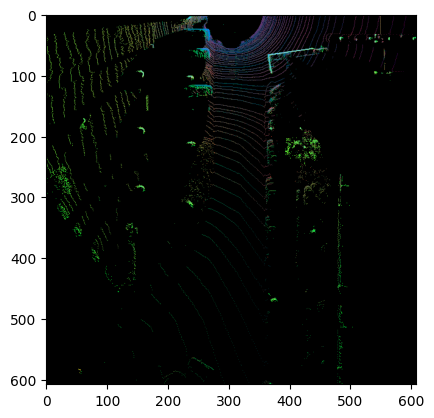

In [16]:
rgb = np.dstack((img_lidar))
plt.imshow(rgb)

# Format input to feed model

In [17]:
import torch
from torchvision import transforms
from PIL import Image

convert_tensor = transforms.ToTensor()

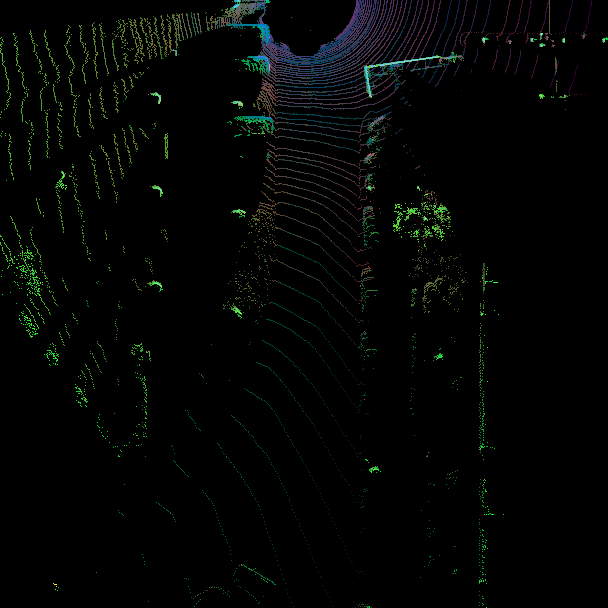

In [18]:
rgbArray = np.zeros((608,608,3), 'uint8')
rgbArray[..., 0] = img_lidar[0]*256
rgbArray[..., 1] = img_lidar[1]*256
rgbArray[..., 2] = img_lidar[2]*256

rgb_pil = Image.fromarray(rgbArray)
rgb_pil

In [19]:
rgb_tensor = convert_tensor(rgb_pil).to(device=configs.device)
rgb_tensor = torch.unsqueeze(rgb_tensor, dim=0)
rgb_tensor.shape

torch.Size([1, 3, 608, 608])

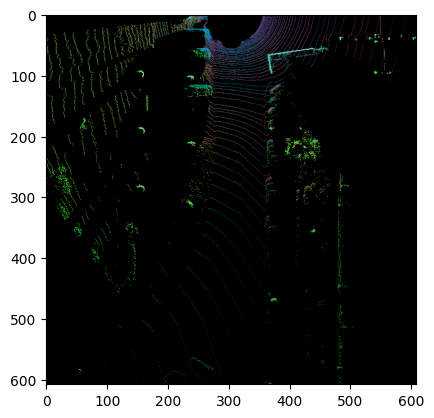

In [20]:
img_bev = rgb_tensor.squeeze() * 255
img_bev = img_bev.cpu().permute(1, 2, 0).numpy().astype(np.uint8)
img_bev = cv2.resize(img_bev, (configs.img_size, configs.img_size))

plt.imshow(img_bev)

## Functions to proyect bbox LiDAR Image (Bird Point of View) to Front Image

In [21]:
from shapely.geometry import Polygon
import data_process.kitti_bev_utils as bev_utils

def rescale_boxes(boxes, current_dim, original_shape):
    """ Rescales bounding boxes to the original shape """
    orig_h, orig_w = original_shape
    # The amount of padding that was added
    pad_x = max(orig_h - orig_w, 0) * (current_dim / max(original_shape))
    pad_y = max(orig_w - orig_h, 0) * (current_dim / max(original_shape))
    # Image height and width after padding is removed
    unpad_h = current_dim - pad_y
    unpad_w = current_dim - pad_x
    # Rescale bounding boxes to dimension of original image
    boxes[:, 0] = ((boxes[:, 0] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 1] = ((boxes[:, 1] - pad_y // 2) / unpad_h) * orig_h
    boxes[:, 2] = ((boxes[:, 2] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 3] = ((boxes[:, 3] - pad_y // 2) / unpad_h) * orig_h

    return boxes

def get_corners_vectorize(x, y, w, l, yaw):
    """bev image coordinates format - vectorization

    :param x, y, w, l, yaw: [num_boxes,]
    :return: num_boxes x (x,y) of 4 conners
    """
    bbox2 = np.zeros((x.shape[0], 4, 2), dtype=np.float32)
    cos_yaw = np.cos(yaw)
    sin_yaw = np.sin(yaw)

    # front left
    bbox2[:, 0, 0] = x - w / 2 * cos_yaw - l / 2 * sin_yaw
    bbox2[:, 0, 1] = y - w / 2 * sin_yaw + l / 2 * cos_yaw

    # rear left
    bbox2[:, 1, 0] = x - w / 2 * cos_yaw + l / 2 * sin_yaw
    bbox2[:, 1, 1] = y - w / 2 * sin_yaw - l / 2 * cos_yaw

    # rear right
    bbox2[:, 2, 0] = x + w / 2 * cos_yaw + l / 2 * sin_yaw
    bbox2[:, 2, 1] = y + w / 2 * sin_yaw - l / 2 * cos_yaw

    # front right
    bbox2[:, 3, 0] = x + w / 2 * cos_yaw - l / 2 * sin_yaw
    bbox2[:, 3, 1] = y + w / 2 * sin_yaw + l / 2 * cos_yaw

    return bbox2

def cvt_box_2_polygon(box):
    """
    :param box: an array of shape [4, 2]
    :return: a shapely.geometry.Polygon object
    """
    # use .buffer(0) to fix a line polygon
    # more infor: https://stackoverflow.com/questions/13062334/polygon-intersection-error-in-shapely-shapely-geos-topologicalerror-the-opera
    return Polygon([(box[i, 0], box[i, 1]) for i in range(len(box))]).buffer(0)

def iou_rotated_single_vs_multi_boxes_cpu(single_box, multi_boxes):
    """
    :param pred_box: Numpy array
    :param target_boxes: Numpy array
    :return:
    """

    s_x, s_y, s_w, s_l, s_im, s_re = single_box
    s_area = s_w * s_l
    s_yaw = np.arctan2(s_im, s_re)
    s_conners = bev_utils.get_corners(s_x, s_y, s_w, s_l, s_yaw)
    s_polygon = cvt_box_2_polygon(s_conners)

    m_x, m_y, m_w, m_l, m_im, m_re = multi_boxes.transpose(1, 0)
    targets_areas = m_w * m_l
    m_yaw = np.arctan2(m_im, m_re)
    m_boxes_conners = get_corners_vectorize(m_x, m_y, m_w, m_l, m_yaw)
    m_boxes_polygons = [cvt_box_2_polygon(box_) for box_ in m_boxes_conners]

    ious = []
    for m_idx in range(multi_boxes.shape[0]):
        intersection = s_polygon.intersection(m_boxes_polygons[m_idx]).area
        iou_ = intersection / (s_area + targets_areas[m_idx] - intersection + 1e-16)
        ious.append(iou_)

    return torch.tensor(ious, dtype=torch.float)

# Model Prediction

In [22]:
predictions = model(rgb_tensor)
predictions.shape

torch.Size([1, 22743, 10])

In [23]:
predictions[0]

tensor([[4.6466e+00, 4.7837e+00, 1.1172e+01,  ..., 5.5503e-03, 9.6080e-01,
         3.9927e-02],
        [1.3958e+01, 3.4893e+00, 1.2008e+01,  ..., 7.5134e-03, 9.4173e-01,
         5.9831e-02],
        [2.1736e+01, 3.7521e+00, 1.1671e+01,  ..., 7.7122e-03, 9.2921e-01,
         7.2374e-02],
        ...,
        [5.2796e+02, 5.9307e+02, 4.4654e+01,  ..., 9.9639e-01, 3.6096e-03,
         3.3539e-03],
        [5.6143e+02, 5.8974e+02, 4.7880e+01,  ..., 9.9571e-01, 4.2948e-03,
         3.9770e-03],
        [5.9180e+02, 5.8884e+02, 4.7064e+01,  ..., 9.9589e-01, 4.1101e-03,
         3.8098e-03]])

### Configure thresholds

In [24]:
conf_thresh=0.95
nms_thresh=0.4

In [25]:
for image_i, image_pred in enumerate(predictions):
    image_pred = image_pred[image_pred[:, 6] >= conf_thresh]
    if not image_pred.size(0):
            continue
    score = image_pred[:, 6] * image_pred[:, 7:].max(dim=1)[0]
    image_pred = image_pred[(-score).argsort()]
    class_confs, class_preds = image_pred[:, 7:].max(dim=1, keepdim=True)
    detections = torch.cat((image_pred[:, :7].float(), class_confs.float(), class_preds.float()), dim=1)

### Save results

In [26]:
output = [None for _ in range(len(predictions))]

keep_boxes = []
while detections.size(0):
    large_overlap = iou_rotated_single_vs_multi_boxes_cpu(detections[0, :6], detections[:, :6]) > nms_thresh
    label_match = detections[0, -1] == detections[:, -1]
    # Indices of boxes with lower confidence scores, large IOUs and matching labels
    invalid = large_overlap & label_match
    weights = detections[invalid, 6:7]
    # Merge overlapping bboxes by order of confidence
    detections[0, :6] = (weights * detections[invalid, :6]).sum(0) / weights.sum()
    keep_boxes += [detections[0]]
    detections = detections[~invalid]
if len(keep_boxes) > 0:
    output[image_i] = torch.stack(keep_boxes)

In [27]:
img_detections = []  # Stores detections for each image index
img_detections.extend(output)

for det in img_detections:
    if det is None:
        continue
    # Rescale boxes to original image
    det = rescale_boxes(det, configs.img_size, img_bev.shape[:2])
    for x, y, w, l, im, re, *_, cls_pred in det:
        yaw = np.arctan2(im, re)
        print(f"X: {x}, Y:{y}, W:{w}, L:{l}, IM:{im}, RE:{re}, YAW:{yaw}")
        # Draw rotated box
        kitti_bev_utils.drawRotatedBox(img_bev, x, y, w, l, yaw, cnf.colors[int(cls_pred)])

X: 247.75091552734375, Y:126.54499053955078, W:23.613338470458984, L:54.70552444458008, IM:0.9923034906387329, RE:-0.038323305547237396, YAW:1.6093976497650146
X: 371.5649108886719, Y:226.71937561035156, W:21.74565887451172, L:45.26185607910156, IM:0.06160469725728035, RE:-0.9906362891197205, YAW:3.0794856548309326
X: 246.0233612060547, Y:65.80453491210938, W:22.876306533813477, L:49.970802307128906, IM:1.0118266344070435, RE:-0.01204622257500887, YAW:1.5827012062072754
X: 254.71144104003906, Y:581.2568969726562, W:22.355915069580078, L:52.571720123291016, IM:0.8674128651618958, RE:-0.5468605756759644, YAW:2.133305311203003
X: 370.394775390625, Y:289.300537109375, W:22.514373779296875, L:49.09970474243164, IM:0.03585648909211159, RE:-0.9874135255813599, YAW:3.105294942855835
X: 370.6436767578125, Y:352.70343017578125, W:22.51015853881836, L:46.946041107177734, IM:0.03277960047125816, RE:-0.990242063999176, YAW:3.108502149581909
X: 371.40899658203125, Y:418.56793212890625, W:22.39514923

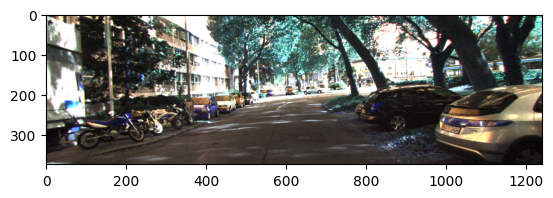

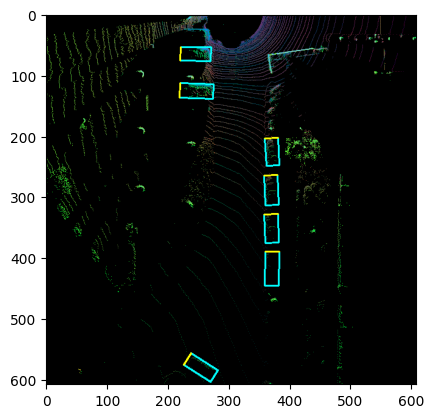

In [28]:
plt.imshow(img_rgb)
plt.show()
plt.imshow(img_bev)
plt.show()

# Proyect BBoxes to Front View

In [30]:
from data_process import kitti_data_utils
from utils.visualization_utils import show_image_with_boxes, predictions_to_kitti_format, merge_rgb_to_bev

In [31]:
calib_path = f'{lidar_root}/calib/{index}.txt'
calib = kitti_data_utils.Calibration(calib_path)
calib

In [32]:
objects_pred = predictions_to_kitti_format(img_detections, calib, img_rgb.shape, configs.img_size)
objects_pred

In [33]:
img_rgb = show_image_with_boxes(img_rgb, objects_pred, calib, False)
img_rgb

array([[[ 72,  53,  40],
        [ 44,  44,  44],
        [ 43,  42,  47],
        ...,
        [ 94, 240, 195],
        [132, 255, 213],
        [127, 255, 251]],

       [[ 64,  63,  39],
        [ 43,  51,  40],
        [ 39,  48,  45],
        ...,
        [100, 232, 226],
        [121, 254, 238],
        [113, 255, 255]],

       [[ 66,  83,  93],
        [ 36,  57,  94],
        [ 18,  46,  61],
        ...,
        [ 89, 193, 202],
        [ 84, 231, 206],
        [ 93, 255, 212]],

       ...,

       [[104, 120, 124],
        [ 98, 121, 135],
        [ 98, 128, 146],
        ...,
        [ 20,  17,   9],
        [ 20,  19,  12],
        [ 19,  17,  14]],

       [[161, 166, 139],
        [164, 169, 140],
        [170, 168, 148],
        ...,
        [ 20,  17,   9],
        [ 22,  21,  10],
        [ 22,  20,  12]],

       [[168, 219, 211],
        [165, 225, 221],
        [173, 222, 236],
        ...,
        [ 19,  14,  20],
        [ 23,  17,  21],
        [ 23,  19,  24]]

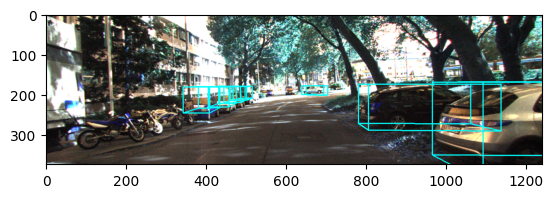

In [34]:
plt.imshow(img_rgb)
plt.show()

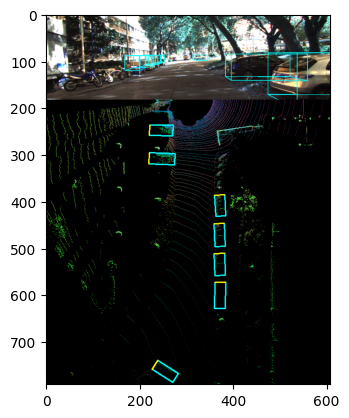

In [35]:
out_img = merge_rgb_to_bev(img_rgb, img_bev, output_width=608)
plt.imshow(out_img)